In [1]:
import sys

%load_ext autoreload
%autoreload 1
%aimport pygenesig.validation
%aimport pygenesig.gini
%aimport pygenesig.bioqc
%aimport pygenesig.tools
%aimport pygenesig.perfmeasures
%matplotlib inline

from pygenesig.validation import * 
from pygenesig.gini import * 
from pygenesig.bioqc import * 
from pygenesig.tools import * 
import pygenesig.perfmeasures as pm
import numpy as np
import pandas as pd
import sklearn.metrics as skm 
import os.path
import dask
from distributed import Client, progress
# import dask.async
import dask.diagnostics

import seaborn as sns
sns.set_style("ticks", {"axes.grid" : True})
from pylab import * 

In [2]:
# sg_kwargs = {'min_gini': .8, 'max_rk': 3, 'min_expr': 5, 'max_rel_rk': .33}
# sg_kwargs = {'min_gini': .8, 'max_rk': 3, 'min_expr': 5, 'max_rel_rk': 1}
sg_kwargs = {} # default args

# Create signature from fantom5

## tissue

In [3]:
expr = np.load("../data/pygenesig/by_gene_sum/tissue_exprs.npy")
target = np.genfromtxt("../data/pygenesig/tissue_target.csv", delimiter=",", dtype=str)
gene_ids = pd.read_csv("../data/pygenesig/by_gene_sum/gene_symbols.csv", header=None, index_col=0)

In [4]:
rosetta = dict(enumerate(gene_ids.index.values))

In [5]:
sg = GiniSignatureGenerator(expr[:, :], target, aggregate_fun=np.median, **sg_kwargs)

/home/sturm/projects/2019/pygenesig/pygenesig/validation.py:115: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not np.issubdtype(expr.dtype, int) and not np.issubdtype(expr.dtype, float):
/home/sturm/projects/2019/pygenesig/pygenesig/validation.py:115: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(expr.dtype, int) and not np.issubdtype(expr.dtype, float):


In [6]:
signatures = sg.mk_signatures()

In [7]:
signatures_id = {
    tissue : [
        rosetta[gene] for gene in genes
    ] for tissue, genes in signatures.items()
}

In [8]:
write_gmt(signatures_id, "../results/tissue.gmt")

## primary cells

In [9]:
expr = np.load("../data/pygenesig/by_gene_sum/primary_exprs.npy")
target_fine = np.genfromtxt("../data/pygenesig/primary_target_fine.csv", delimiter=",", dtype=str)
target_coarse = np.genfromtxt("../data/pygenesig/primary_target_coarse.csv", delimiter=",", dtype=str)
gene_ids = pd.read_csv("../data/pygenesig/by_gene_sum/gene_symbols.csv", header=None, index_col=0)

In [10]:
rosetta = dict(enumerate(gene_ids.index.values))

In [11]:
sg_fine = GiniSignatureGenerator(expr[:, :], target_fine, aggregate_fun=np.median, **sg_kwargs)
sg_coarse = GiniSignatureGenerator(expr[:, :], target_coarse, aggregate_fun=np.median, **sg_kwargs)

In [12]:
signatures_fine = sg_fine.mk_signatures()

In [13]:
signatures_coarse= sg_coarse.mk_signatures()

In [14]:
signatures_fine_id = {
    tissue : [
        rosetta[gene] for gene in genes
    ] for tissue, genes in signatures_fine.items()
}

In [15]:
signatures_coarse_id = {
    tissue : [
        rosetta[gene] for gene in genes
    ] for tissue, genes in signatures_coarse.items()
}

### merge fine to form coarse signatures again

In [16]:
signatures_coarse_merged = {tissue: [] for tissue in signatures_coarse_id}

for tissue_fine, genes_fine  in signatures_fine_id.items(): 
    tissue_coarse = tissue_fine.split("-")[0].strip()
    signatures_coarse_merged[tissue_coarse].extend(genes_fine)
    
signatures_coarse_merged = {
    tissue: set(genes) for tissue, genes in signatures_coarse_merged.items()
}

### write results to gmt

In [17]:
write_gmt(signatures_fine_id, "../results/primary_fine.gmt")
write_gmt(signatures_coarse_id, "../results/primary_coarse.gmt")
write_gmt(signatures_coarse_merged, "../results/primary_coarse_merged.gmt")

### compare merged vs. direct computation

In [18]:
def jaccard_mat(sigs1, sigs2):
    for name1, genes1 in sigs1.items():
        for name2, genes2 in sigs2.items():
            yield (name1, name2, jaccard_ind(set(genes1), set(genes2)))

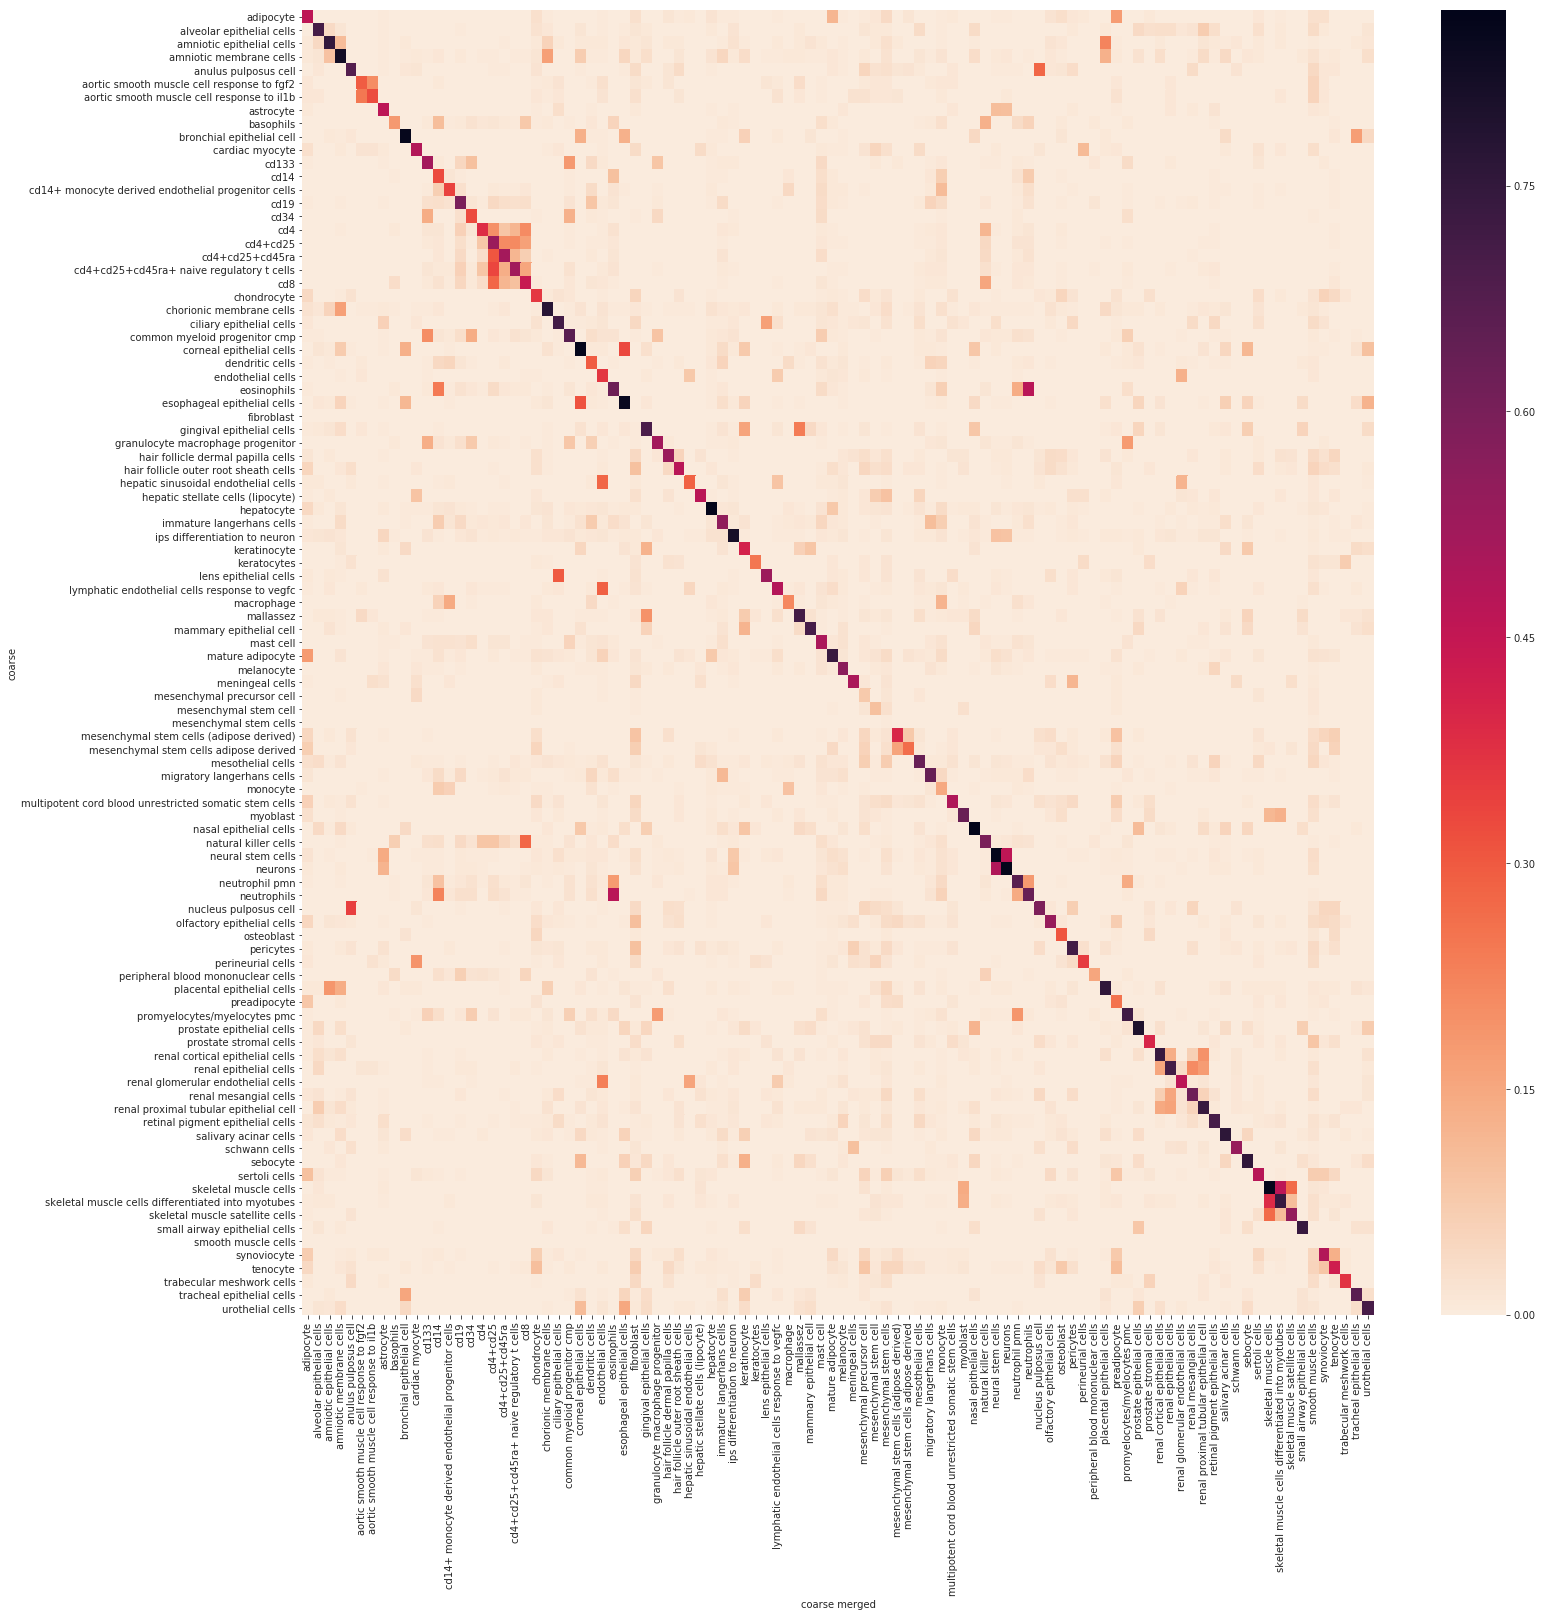

In [19]:
fig, ax = subplots(figsize=(24, 24))
df = pd.DataFrame(
    jaccard_mat(signatures_coarse_id, signatures_coarse_merged),
    columns=("coarse", "coarse merged", "jaccard"),
)
sns.heatmap(
    df.pivot(*df.columns), ax=ax, cmap=sns.cm.rocket_r,
)